In [ ]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git
!pip install imgaug
!pip install -U opencv-python

!gdown --id 1S_vKl5E1z7yK7KQyHVTmwacWHlfmohV1 #download detector weights
!gdown --id 1CoHp2jck0GK8ogkazgaACV5o4F0SoMCD #download recognizer weights
!gdown --id 1SE3TSVITtvqOe_wPfrOHkEaIbg9G93tF #download file test obat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-req-build-hq1xa1ft
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-req-build-hq1xa1ft
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.5 MB 5.2 MB/s 
     |████████████████████████████████| 603 kB 44.6 MB/s 
     |████████████████████████████████| 930 kB 49.1 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.9.0.post2+40bb9bd-py3-none-any.whl size=42441 sha256=395ed38f34cb967c37e2cf7ce5f322a5231d7070ae68addf74cc2ca4a5851340
  Stored in directory: /tmp/pip-ephem-wheel-cache-4aw0sv_i/wheels/20/d0/06/ed290995144ec8dde71d3a91d0d590145445c01be60ea70c9b
  Created wheel for validators: filename=validators-0.20

In [ ]:
!unzip "./test_obat.zip"

Archive:  ./test_obat.zip
  inflating: Acarbose.jpg            
  inflating: Cetirizine.jpg          
  inflating: Decolgen.jpg            
  inflating: Decolgen_crop.jpg       
  inflating: Decolsin.jpg            
  inflating: Decolsin_2.jpg          
  inflating: Panadol.jpg             
  inflating: Paramex.jpg             
  inflating: Paramex_2.jpg           
  inflating: Promag.jpg              


In [ ]:
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import string

import keras_ocr

dir = "."

In [ ]:
alphabet = string.digits + string.ascii_letters + '!?., /\\"\'@()<>-'
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))

In [ ]:
detector = keras_ocr.detection.Detector()
recognizer = keras_ocr.recognition.Recognizer(alphabet=recognizer_alphabet)
recognizer.compile()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [ ]:
detector.model.load_weights(os.path.join(dir, "detector_icdar2013.h5"))
recognizer.model.load_weights(os.path.join(dir, "recognizer_icdar2013.h5"))

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer, detector=detector)

In [ ]:
DETECTION_KWARGS = {
    "detection_threshold":0.7,
    "text_threshold":0.4,
    "link_threshold":0.4,
    "size_threshold":400,
}

In [ ]:
import cv2

def getBoxes(
    y_pred,
    detection_threshold=0.7,
    text_threshold=0.4,
    link_threshold=0.4,
    size_threshold=10,
):
    box_groups = []
    for y_pred_cur in y_pred:
        # Prepare data
        textmap = y_pred_cur[..., 0].copy()
        linkmap = y_pred_cur[..., 1].copy()
        img_h, img_w = textmap.shape

        _, text_score = cv2.threshold(
            textmap, thresh=text_threshold, maxval=1, type=cv2.THRESH_BINARY
        )
        _, link_score = cv2.threshold(
            linkmap, thresh=link_threshold, maxval=1, type=cv2.THRESH_BINARY
        )
        n_components, labels, stats, _ = cv2.connectedComponentsWithStats(
            np.clip(text_score + link_score, 0, 1).astype("uint8"), connectivity=4
        )
        boxes = []
        for component_id in range(1, n_components):
            # Filter by size
            size = stats[component_id, cv2.CC_STAT_AREA]

            if size < size_threshold:
                continue

            # If the maximum value within this connected component is less than
            # text threshold, we skip it.
            if np.max(textmap[labels == component_id]) < detection_threshold:
                continue

            # Make segmentation map. It is 255 where we find text, 0 otherwise.
            segmap = np.zeros_like(textmap)
            segmap[labels == component_id] = 255
            segmap[np.logical_and(link_score, text_score)] = 0
            x, y, w, h = [
                stats[component_id, key]
                for key in [
                    cv2.CC_STAT_LEFT,
                    cv2.CC_STAT_TOP,
                    cv2.CC_STAT_WIDTH,
                    cv2.CC_STAT_HEIGHT,
                ]
            ]

            # Expand the elements of the segmentation map
            niter = int(np.sqrt(size * min(w, h) / (w * h)) * 2)
            sx, sy = max(x - niter, 0), max(y - niter, 0)
            ex, ey = min(x + w + niter + 1, img_w), min(y + h + niter + 1, img_h)
            segmap[sy:ey, sx:ex] = cv2.dilate(
                segmap[sy:ey, sx:ex],
                cv2.getStructuringElement(cv2.MORPH_RECT, (1 + niter, 1 + niter)),
            )

            # Make rotated box from contour
            contours = cv2.findContours(
                segmap.astype("uint8"),
                mode=cv2.RETR_TREE,
                method=cv2.CHAIN_APPROX_SIMPLE,
            )[-2]
            contour = contours[0]
            box = cv2.boxPoints(cv2.minAreaRect(contour))

            # Check to see if we have a diamond
            w, h = np.linalg.norm(box[0] - box[1]), np.linalg.norm(box[1] - box[2])
            box_ratio = max(w, h) / (min(w, h) + 1e-5)
            if abs(1 - box_ratio) <= 0.1:
                l, r = contour[:, 0, 0].min(), contour[:, 0, 0].max()
                t, b = contour[:, 0, 1].min(), contour[:, 0, 1].max()
                box = np.array([[l, t], [r, t], [r, b], [l, b]], dtype=np.float32)
            else:
                # Make clock-wise order
                box = np.array(np.roll(box, 4 - box.sum(axis=1).argmin(), 0))
            boxes.append(2 * box)
        box_groups.append(np.array(boxes))
    return box_groups

In [ ]:
#pipeline = keras_ocr.pipeline.Pipeline(detector=detector)

# Get a set of three example images
images = [
    keras_ocr.tools.read(url) for url in [
        "./Promag.jpg",
    ]
]

im = images[0]
im = im[np.newaxis]
im = im.astype('float32')/255 

print(im.shape)
# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
#prediction_groups = pipeline.recognize(images, DETECTION_KWARGS)
prediction = detector.model.predict(im)
box_groups = getBoxes(prediction, size_threshold=100)
# Plot the predictions

(1, 500, 500, 3)


In [ ]:
prediction_groups = recognizer.recognize_from_boxes(
    images=images,
    box_groups=box_groups,
)

In [ ]:
print(prediction_groups[0])

['promag', 'hwudohlte', 'magonesum', 'simethicone', 'hveroxide']


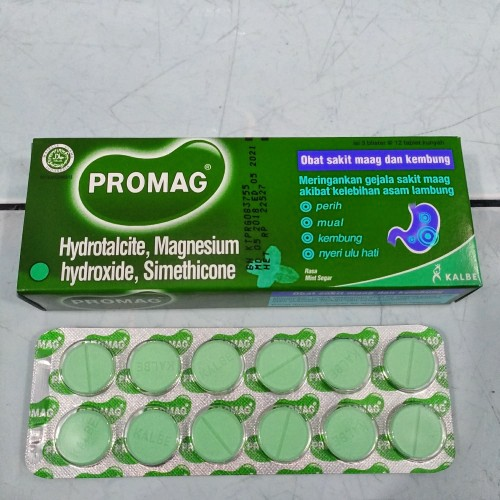

In [ ]:
from google.colab.patches import cv2_imshow
for image in images:
  cv2_imshow(image)